In [108]:
import glob
import numpy as np
import pandas as pd
import cv2
import random 
import math
import os
import sys
import ipynb
import importlib
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
from skimage import transform
from torch.autograd import Variable

In [60]:
import ipynb.fs.full.BeeDataHandler as BeeDataHandler

In [61]:
importlib.reload(BeeDataHandler)

<module 'ipynb.fs.full.BeeDataHandler' (/Users/dieumynguyen/Documents/S2019_ObjectOrientedDesign/PyTorchPresentation/BeeHealthClassification_orig/BeeDataHandler.ipynb)>

### Parameters

In [135]:
IMG_SIZE = 16
BATCH_SIZE = 4
BW = True

bee_dir = '/Users/dieumynguyen/Datasets/HoneyBees'

### Define transformations for data augmentation

In [136]:
transforms_np = [
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomRotation(degrees=180),
#     transforms.RandomAffine(degrees=180, translate=(0, 0.2)),
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),  # Always need, div by 255 
    BeeDataHandler.CustomNormalize()
]

if BW:
    transforms_np.append(BeeDataHandler.Flatten())

transform_list = transforms.Compose(transforms_np)

### Load data

In [137]:
# Wrapper around the data
# Could load data into np or a pointer/filepath
bee_data_src = BeeDataHandler.DataHandler(bee_dir, transforms=transform_list, bw=BW, test_split=0.2)

In [138]:
train_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.train_sampler)
test_dataloader = DataLoader(bee_data_src, batch_size=BATCH_SIZE, sampler=bee_data_src.test_sampler)

In [139]:
def sample_imgs():
    for X, y in train_dataloader:
        break
    
    X = X.view(-1, IMG_SIZE)
    
    xxx = (X + 1) / 2.0
    grid_img = utils.make_grid(xxx)

    fig, ax = plt.subplots(figsize=(12,12))
    ax.imshow(grid_img.permute(1,2,0))
    recovered_labels = [bee_data_src.idx_to_key[ele.item()] for ele in y]
    title_str = ""
    for recovered_label in recovered_labels:
        title_str += f"{recovered_label}                     "
    title_str = title_str[:-3]
    plt.title(title_str)

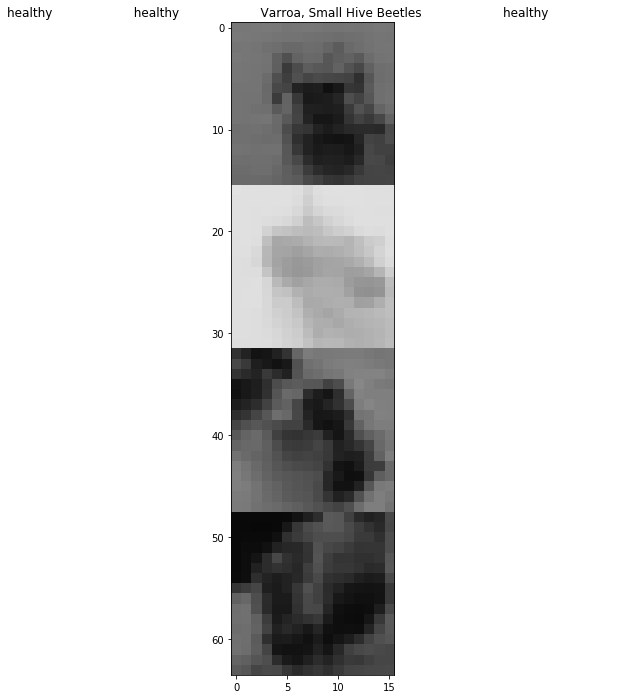

In [140]:
sample_imgs()

### CNN

$$ out = \frac{in - k + 2*P}{stride} + 1$$

$$ in = [(in - k + 2P) / S] + 1$$ 
$$ P = (S(in - 1) - in + k ) / 2$$ 
$$ P = (S*in - S - in + k ) / 2$$ 
$$ P = (in(S - 1) - S + k ) / 2$$ 

if S == 1:
$$ P = (k-S) / 2$$ 

In [141]:
xx = nn.Linear(5, 1)
xx.weight

Parameter containing:
tensor([[-0.0482,  0.4368,  0.1657, -0.2929, -0.3883]], requires_grad=True)

In [142]:
class MLP(nn.Module):
    
    def __init__(self, num_classes, num_in_channels, input_dim, keep_prob=1.0):
        '''
        In this constructor, define layers using provided modiles from nn package.
        A Sequential is defined by a sequence of a layer, normalization, activation, pooling.
        '''
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 512)
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(512, 512)
        nn.init.xavier_uniform_(self.fc2.weight)
        
        self.fc3 = nn.Linear(512, num_classes)
        nn.init.xavier_uniform_(self.fc3.weight)
        
        self.dropout = nn.Dropout(p=1-keep_prob)
        self.activation = nn.ReLU()

        """ ---------------------------------------- """
        
    def forward(self, x):
        ''' 
        This function is called on the net for a set of inputs,
        and it passes that input through different layers defined above.
        
        For ex, we pass x through first layer, pass its output through
        second layer, and pass that through the final FC layer to get 
        final output. 
        '''
    
        # Fully Connected
        out = self.activation(self.fc1(x))
        out = self.dropout(out)
        
        out = self.activation(self.fc2(out))
        out = self.dropout(out)
        
        out = self.activation(self.fc3(out))
        
        return out
        

In [143]:
num_epochs = 1000
learning_rate = 0.0005

# Instantiate an instance of the conv net
num_classes = bee_data_src.num_classes
num_in_channels = 1 if BW else 3
flat_shape = IMG_SIZE * IMG_SIZE
net = MLP(input_dim=flat_shape, num_classes=num_classes, num_in_channels=num_in_channels)

# Loss function and optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

losses = []
test_accuracies = []
train_accuracies = []

### Train

In [144]:
def evaluate_model(dataset_key):
    net.eval()
    correct = 0
    total = 0
    data_loader = train_dataloader if dataset_key == 'train' else test_dataloader
    for images, labels in data_loader:
        outputs = net(images)
        predicted_vals, predicted_idxs = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted_idxs == labels).sum()

    accuracy = 100 * correct / float(total)
    print(f"\n{dataset_key.capitalize()} accuracy: {accuracy:0.2f}%")
    return accuracy

In [158]:
try:
    for epoch_i in range(len(losses), num_epochs):
        net.train()
        batch_losses = []
        for batch_i, (images, labels) in enumerate(train_dataloader):

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Add loss values to array to print out progress of training
            batch_losses.append(loss.item()) 

            if (batch_i+1) % 50 == 0:
                num_batches = len(train_dataloader)
                
                if losses == []:
                    epoch_loss_val = 9999
                else:
                    epoch_loss_val = losses[-1]
                batch_loss_val = np.mean(batch_losses)
                print_str = f'\rEpoch: {epoch_i+1}/{num_epochs} -- '
                print_str += f'Epoch Loss: {epoch_loss_val:0.4f} -- '
                print_str += f'Batch: {batch_i+1}/{num_batches} -- '
                print_str += f'Batch Loss: {batch_loss_val:0.4f}'
                
                sys.stdout.write(print_str)
                sys.stdout.flush()

        if epoch_i % 1 == 0:
            train_acc = evaluate_model('train')
            train_accuracies.append((epoch_i, train_acc))
            
            test_acc = evaluate_model('test')
            test_accuracies.append((epoch_i, test_acc))
            
        losses.append(np.mean(batch_losses))
except KeyboardInterrupt:
    print("\nEnding Early.")

Epoch: 27/1000 -- Epoch Loss: 0.2725 -- Batch: 1000/1035 -- Batch Loss: 0.2784
Train accuracy: 88.00%

Test accuracy: 77.00%
Epoch: 28/1000 -- Epoch Loss: 0.2794 -- Batch: 1000/1035 -- Batch Loss: 0.2866
Train accuracy: 88.00%

Test accuracy: 76.00%
Epoch: 29/1000 -- Epoch Loss: 0.2892 -- Batch: 1000/1035 -- Batch Loss: 0.2612
Train accuracy: 89.00%

Test accuracy: 77.00%
Epoch: 30/1000 -- Epoch Loss: 0.2600 -- Batch: 1000/1035 -- Batch Loss: 0.2457
Train accuracy: 89.00%

Test accuracy: 78.00%
Epoch: 31/1000 -- Epoch Loss: 0.2445 -- Batch: 1000/1035 -- Batch Loss: 0.2486
Train accuracy: 87.00%

Test accuracy: 76.00%
Epoch: 32/1000 -- Epoch Loss: 0.2488 -- Batch: 1000/1035 -- Batch Loss: 0.2841
Train accuracy: 88.00%

Test accuracy: 76.00%
Epoch: 33/1000 -- Epoch Loss: 0.2848 -- Batch: 1000/1035 -- Batch Loss: 0.2589
Train accuracy: 88.00%

Test accuracy: 78.00%
Epoch: 34/1000 -- Epoch Loss: 0.2562 -- Batch: 1000/1035 -- Batch Loss: 0.2447
Train accuracy: 89.00%

Test accuracy: 78.00%


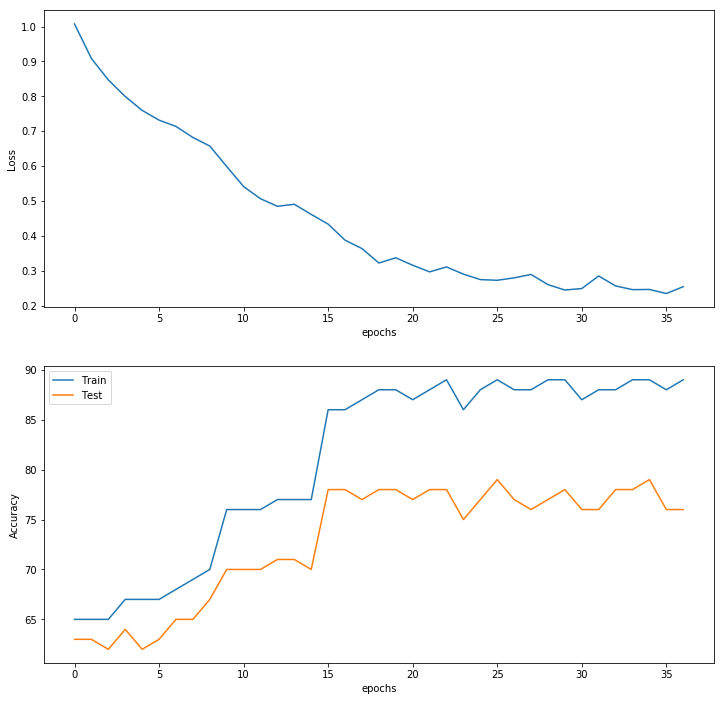

In [159]:
train_accs = np.array(train_accuracies)
test_accs = np.array(test_accuracies)

fig, ax = plt.subplots(2, 1, figsize=(12,12))
ax[0].plot(losses)
ax[0].set(xlabel="epochs", ylabel='Loss')
# ax[1].plot(train_accs[:,0], train_accs[:,1], label='Train')
# ax[1].plot(test_accs[:,0], test_accs[:,1], label='Test')
ax[1].plot(train_accs[:,1], label='Train')
ax[1].plot(test_accs[:,1], label='Test')
ax[1].set(xlabel="epochs", ylabel='Accuracy')
ax[1].legend()

In [160]:
net.eval()
confusion_matrix = torch.zeros((num_classes, num_classes))
for X, y in train_dataloader:
    outputs = net(X)
    y_preds = outputs.max(dim=1)[1]
    for y_true, y_pred in zip(y, y_preds):
        confusion_matrix[y_true, y_pred] += 1
    
    
outputs.shape

torch.Size([2, 6])

[Text(33.0, 0.5, 'Actual'), Text(0.5, 15.0, 'Predicted')]

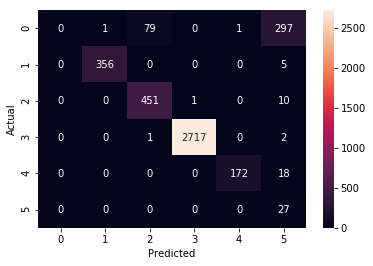

In [161]:
ax = sns.heatmap(confusion_matrix.int(), annot=True, fmt="d")
ax.set(xlabel="Predicted", ylabel="Actual")